In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.metrics.intrinsic_dimension import IntrinsicDimension
from src.metrics.clustering import LabelClustering
from src.utils.tensor_storage import retrieve_from_storage, preprocess_label
from src.metrics.probe import LinearProbe
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from src.utils.tensor_storage import preprocess_label
import datasets
plot_config = {
    #'font.size': 12,           
    'axes.titlesize': 30,      
    'axes.labelsize': 29,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 23,
    'figure.figsize': (10,8),
    'lines.linewidth': 2.5,
    'lines.markersize': 10,
}


/u/dssc/zenocosini/helm_suite/representation_landscape_fs_ft/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def plotter(data, title, ylabel):
    # Set the style
    sns.set_style(
        "whitegrid",
        rc={"axes.edgecolor": ".15", "xtick.bottom": True, "ytick.left": True},
    )
    # Setup figure and axes for 2 plots in one row
    plt.figure(dpi = 200)
    layers = np.arange(0,data[0].shape[0])

    #Set ticks
    if layers.shape[0] < 50:
        tick_positions = np.arange(0, layers.shape[0], 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(0, layers.shape[0], 8)  # Generates positions 0, 4, 8, ...

    tick_labels = tick_positions +1 # Get the corresponding labels from x

    
    names = ["0 shot pt", 
            "1 shot pt", 
            "2 shot pt",
            "5 shot pt"]
            #"0 shot ft"]
    markerstyle = ['o', 'o', 'o', 'o']#, 'x']
    
    for int_dim, label, markerstyle in zip(data, names, markerstyle):
        sns.scatterplot(x=layers, y=int_dim, marker= markerstyle)
        sns.lineplot(x=layers, y=int_dim, label=label)


    plt.xlabel("Layer")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(ticks=tick_positions, labels=tick_labels)
    tick_positions_y = np.arange(0, 0.7, 0.7/10).round(3)
    plt.yticks(tick_positions_y)
    plt.tick_params(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.rcParams.update(plot_config)
    plt.show()

## Dataset

In [5]:
train_path = Path("/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/diego/science_qa/category_partition/train")
test_path = Path("/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/diego/science_qa/category_partition/test")
train = datasets.load_from_disk(train_path).to_pandas()
test = datasets.load_from_disk(test_path).to_pandas()

In [6]:
category_to_exclude = [
    "Phrases and clauses"
    "Verb tense",
    "Developing and supporting arguments",
    "Formatting"
    "Sentences, fragments, and run-ons",
    "Literary devices",
    "Creative techniques",
    "Supply and demand",
    "Rhyming",
    "Short and long vowels",
    "Poetry elements",
    "Historical figures",
    "Pronouns and antecedents",
    "Cells",
    "Author's purpose and tone",
    "Thermal energy",
    "States of matter",
    "Earth events",
    "Kinetic and potential energy",
    "Social studies skills",
    "Economics",
    "Editing and revising",
    "Categories",
    "Government",
    "Shades of meaning",
    "Animals",
    "Comprehension strategies",
    "Research skills",
    "Plants",
    "Opinion writing",
    "Mixtures"]
category_to_include = [
    "Physical and chemical change",
    "Literary devices",
    "Chemical reactions",
    "Heat and thermal energy",
    "Basic economic principles",
    "Weather and climate",
    "Atoms and molecules",
    "Rocks and minerals"]
rows_to_keep = test.query(f"category in {category_to_include}").index.to_numpy()

In [7]:
# test.query(f"category=='Force and motion'")
# test.query(f"category in {category_to_include}")
topics = test.topic.to_list()

In [5]:
subjects_test = preprocess_label(test.category.to_list(), 32)


## Clustering

/u/dssc/zenocosini/helm_suite/representation_landscape_fs_ft/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing layers: 100%|██████████| 32/32 [01:17<00:00,  2.42s/it]


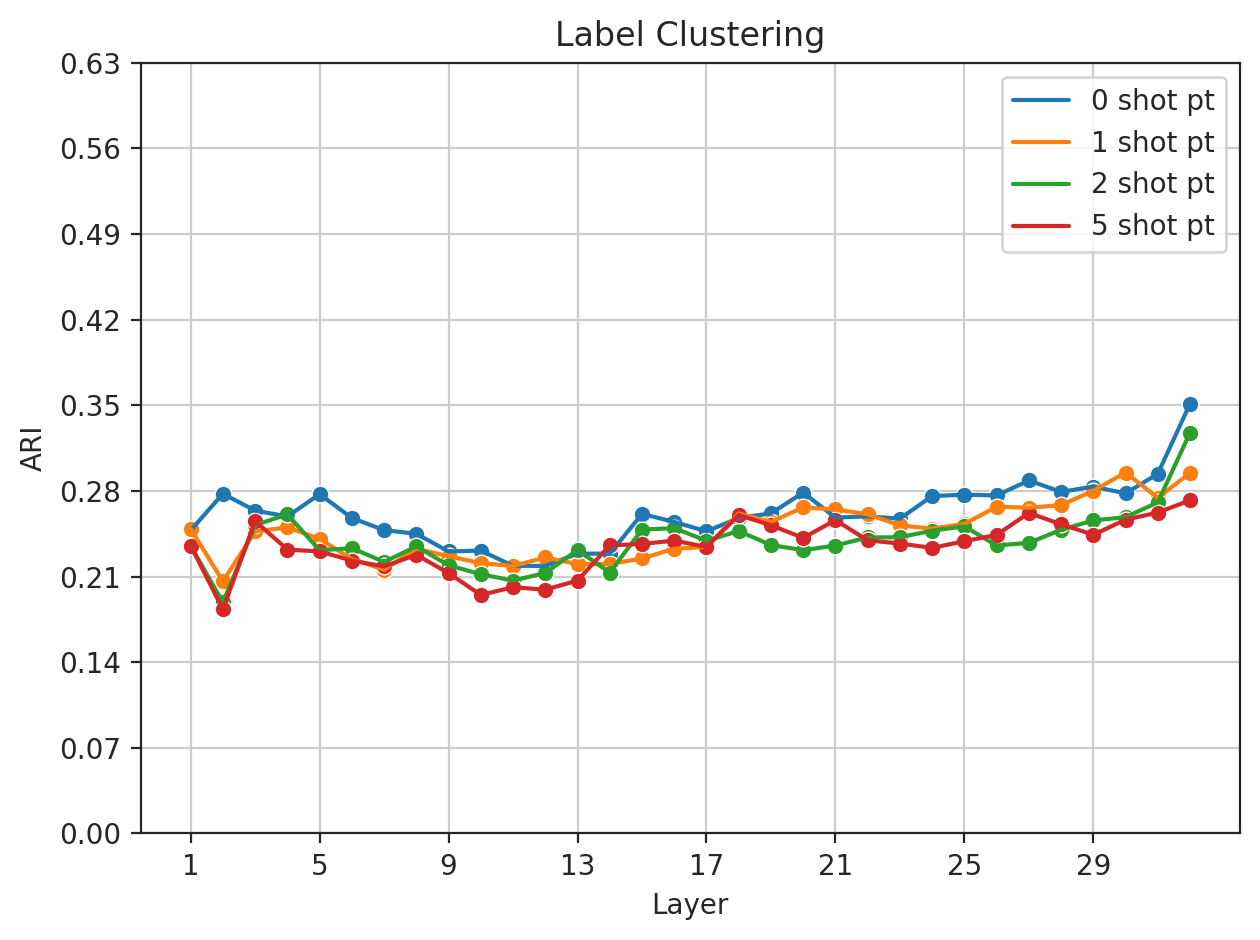

In [8]:
_PATH = Path("/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens"
             "/repo/results/scienceqa/few_shot_category/evaluated_test/llama-3-8b")

shot = [0,1,2,5]
data_subjects = []
for i in shot:
    clustering = LabelClustering()
    out_from_storage = retrieve_from_storage(_PATH / f'{i}shot',
                                            full_tensor=True)
    tensors, labels, number_of_layers = out_from_storage
    # tensors = tensors[:, rows_to_keep]
    #labels = labels["subjects"][:, rows_to_keep]
    labels = topic
    labels = preprocess_label(labels, 32)
    data_subjects.append(clustering.main(z=1.6,
                                tensors=tensors,
                                labels=labels,
                                number_of_layers=number_of_layers,
                                parallel=True))
    
ari = [np.array(i['adjusted_rand_score']) for i in data_subjects]
plotter(ari, "Label Clustering", "ARI")


In [7]:
_PATH = Path("/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens"
             "/repo/results/scienceqa/evaluated_test/llama-3-8b")

shot = [0,1,2,5]
data_preds = []
for i in shot:
    clustering = LabelClustering(path= _PATH / f'{i}shot')
    data_preds.append(clustering.main(label="predictions",
                                z=1.6,
                                instance_per_sub=-1,
                                full_tensor=True))
    
ari = [np.array(i['adjusted_rand_score']) for i in data_preds]
plotter(ari, "Label Clustering", "ARI")


TypeError: LabelClustering.__init__() got an unexpected keyword argument 'path'

## Probe

In [9]:
_PATH = Path("/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens"
             "/repo/results/scienceqa/few_shot_category/evaluated_test/llama-3-8b")

shot = [0,1,2,5]
data_preds = []
labels = preprocess_label(topics, 32)
for i in shot:
    out_from_storage = retrieve_from_storage(_PATH / f'{i}shot',
                                             full_tensor=True)
    tensors, _, _ = out_from_storage
    linear_probe = LinearProbe()
    data_preds.append(linear_probe.main(
                                tensors=tensors,
                                labels=labels,
                                number_of_layers=tensors.shape[0],
                                parallel=True))
    
plotter(data_preds, "Linear Probe", "Accuracy")


TypeError: LinearProbe.main() missing 1 required positional argument: 'label'

# TMP


In [ ]:
with open( _PATH / "0shot/statistics_target.pkl", "rb") as f:
    stats = pickle.load(f)

In [ ]:
np.unique(stats["predictions"], return_counts=True)

(array(['A', 'B', 'C', 'D', 'acquired'], dtype='<U8'),
 array([5057, 3545,  894,  282,    8]))

In [ ]:
import torch
act = torch.load(_PATH / "0shot/l28_target.pt", weights_only=True)
act = act.to(torch.float64).numpy()
act, idx, inverse = np.unique(act, axis=0, return_index=True, return_inverse=True)
assert len(inverse)==len(idx)

/tmp/ipykernel_3413931/336141325.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act = torch.load(_PATH / "0shot/l28_target.pt")
